In [1]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term


### Analytical Solution

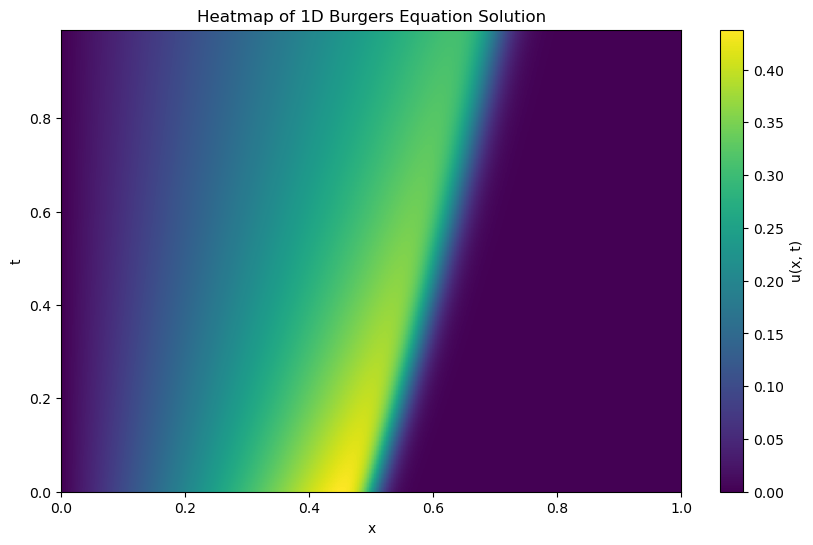

In [2]:
# Define the Reynolds number for the analytical solution
# Re = 1,50,100,300
Re_fixed = 300

# Define the spatial and temporal grid
N_t = 100  # Number of time points
N_x = 256  # Number of spatial points
t = np.linspace(0, 0.99, N_t)  # Time grid
x = np.linspace(0, 1, N_x)    # Spatial grid

# Define the analytical solution for the 1D Burgers equation
def analytical_solution(x, t, Re_fixed):
    to = np.exp(Re_fixed / 8)  # Parameter in the equation
    u = x / (t + 1) / (1 + np.sqrt((t + 1) / to) * np.exp(Re_fixed * x**2 / (4 * (t + 1))))
    return u

# Compute the solution
usol = np.array([[analytical_solution(xi, ti, Re_fixed) for xi in x] for ti in t])

# Explicitly enforce boundary conditions
usol[:, 0] = 0  # u(0, t) = 0
usol[:, -1] = 0  # u(1, t) = 0

# Verify the boundary conditions
assert np.allclose(usol[:, 0], 0), "Boundary condition u(0, t) = 0 not satisfied"
assert np.allclose(usol[:, -1], 0), "Boundary condition u(1, t) = 0 not satisfied"

# Save the data to a .npz file
np.savez("dataset/Burgers.npz", t=t, x=x, usol=usol)

# Create a new figure window with a size of 10x6 inches
plt.figure(figsize=(10, 6))

# Plot the heatmap
# `usol` is the 2D array containing the solution, `extent` specifies the range for x and t axes,
# `origin='lower'` ensures the heatmap starts from the bottom-left corner,
# `aspect='auto'` adjusts the aspect ratio automatically, and `cmap='viridis'` sets the colormap
plt.imshow(usol, extent=[x.min(), x.max(), t.min(), t.max()], 
           origin='lower', aspect='auto', cmap='viridis')

# Add a colorbar to indicate the value of u(x, t) for each color
plt.colorbar(label="u(x, t)")

plt.title("Heatmap of 1D Burgers Equation Solution")
plt.xlabel("x")
plt.ylabel("t")

plt.show()

### Part (a): Forward Problem

Training for fixed Re = 300
Compiling model...
Building feed-forward neural network...
'build' took 0.062156 s




C:\Users\jhyang\AppData\Local\Temp\ipykernel_13140\2581919726.py:27: RuntimeWarning: overflow encountered in multiply
  geomtime, lambda x: x[:, 0:1] / (1 + np.sqrt(np.exp(Re_fixed / 8)) * np.exp(Re_fixed * x[:, 0:1]**2 / 4)),


'compile' took 0.536863 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.64e-01, 3.06e-01, 1.04e-01]    [3.64e-01, 3.06e-01, 1.04e-01]    []  
1000      [3.86e-06, 2.40e-07, 9.00e-08]    [3.86e-06, 2.40e-07, 9.00e-08]    []  
2000      [7.97e-07, 7.66e-08, 1.24e-07]    [7.97e-07, 7.66e-08, 1.24e-07]    []  
3000      [2.56e-07, 1.81e-08, 3.10e-08]    [2.56e-07, 1.81e-08, 3.10e-08]    []  
4000      [1.02e-07, 9.12e-09, 1.55e-08]    [1.02e-07, 9.12e-09, 1.55e-08]    []  
5000      [4.94e-08, 6.67e-09, 1.64e-08]    [4.94e-08, 6.67e-09, 1.64e-08]    []  
6000      [3.41e-08, 5.10e-09, 1.74e-08]    [3.41e-08, 5.10e-09, 1.74e-08]    []  
7000      [2.65e-08, 4.10e-09, 1.62e-08]    [2.65e-08, 4.10e-09, 1.62e-08]    []  
8000      [2.18e-08, 3.40e-09, 1.38e-08]    [2.18e-08, 3.40e-09, 1.38e-08]    []  
9000      [2.44e-08, 1.72e-08, 2.16e-08]    [2.44e-08, 1.72e-08, 2.16e-08]    []  
10000     [1.75e-08, 2.40e-09, 9.8

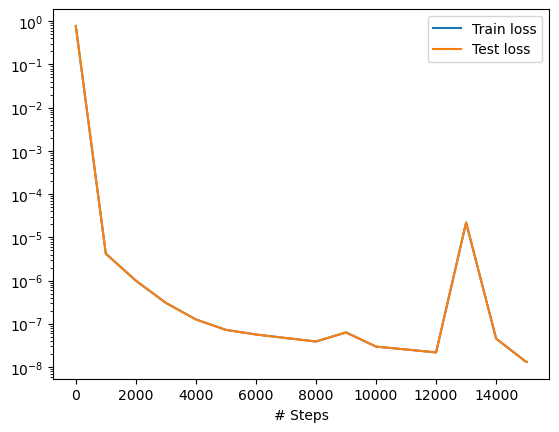

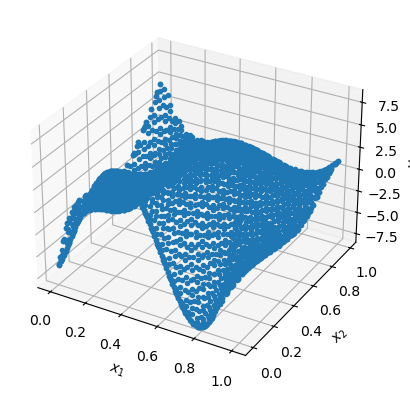

Fixed Re = 300, Mean residual: 7.184265996329486e-05
Fixed Re = 300, L2 relative error: 1.0000199376441774


In [3]:
# Define fixed Reynolds number
# Re = 1,50,100,300
Re_fixed = 300

# Generate analytical test data
def gen_testdata():
    data = np.load("dataset/Burgers.npz")  # Ensure the file is present in the correct location
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

# Define the PDE
def pde(x, y, Re):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 3 / Re * dy_xx # Re=Re_fixed/100

# Define the domain and conditions
geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.IC(
    geomtime, lambda x: x[:, 0:1] / (1 + np.sqrt(np.exp(Re_fixed / 8)) * np.exp(Re_fixed * x[:, 0:1]**2 / 4)),
    lambda _, on_initial: on_initial
)

# Solve the forward problem for fixed Re
print(f"Training for fixed Re = {Re_fixed}")

# Define dataset for fixed Re
data_fixed = dde.data.TimePDE(
    geomtime, lambda x, y: pde(x, y, Re_fixed), [bc, ic], num_domain=2540, num_boundary=80, num_initial=160
)

# Define the neural network
net_fixed = dde.maps.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model_fixed = dde.Model(data_fixed, net_fixed)
model_fixed.compile("adam", lr=1e-3)

# Train the model
model_fixed.train(epochs=15000)
model_fixed.compile("L-BFGS")
losshistory_fixed, train_state_fixed = model_fixed.train()

# Save results
dde.saveplot(losshistory_fixed, train_state_fixed, issave=True, isplot=True)

# Test the model
X_fixed, y_true_fixed = gen_testdata()
y_pred_fixed = model_fixed.predict(X_fixed)
f_fixed = model_fixed.predict(X_fixed, operator=lambda x, y: pde(x, y, Re_fixed))

# Print errors for fixed Re
print(f"Fixed Re = {Re_fixed}, Mean residual: {np.mean(np.absolute(f_fixed))}")
print(f"Fixed Re = {Re_fixed}, L2 relative error: {dde.metrics.l2_relative_error(y_true_fixed, y_pred_fixed)}")
np.savetxt(f"test_fixed_Re_{Re_fixed}.dat", np.hstack((X_fixed, y_true_fixed, y_pred_fixed)))

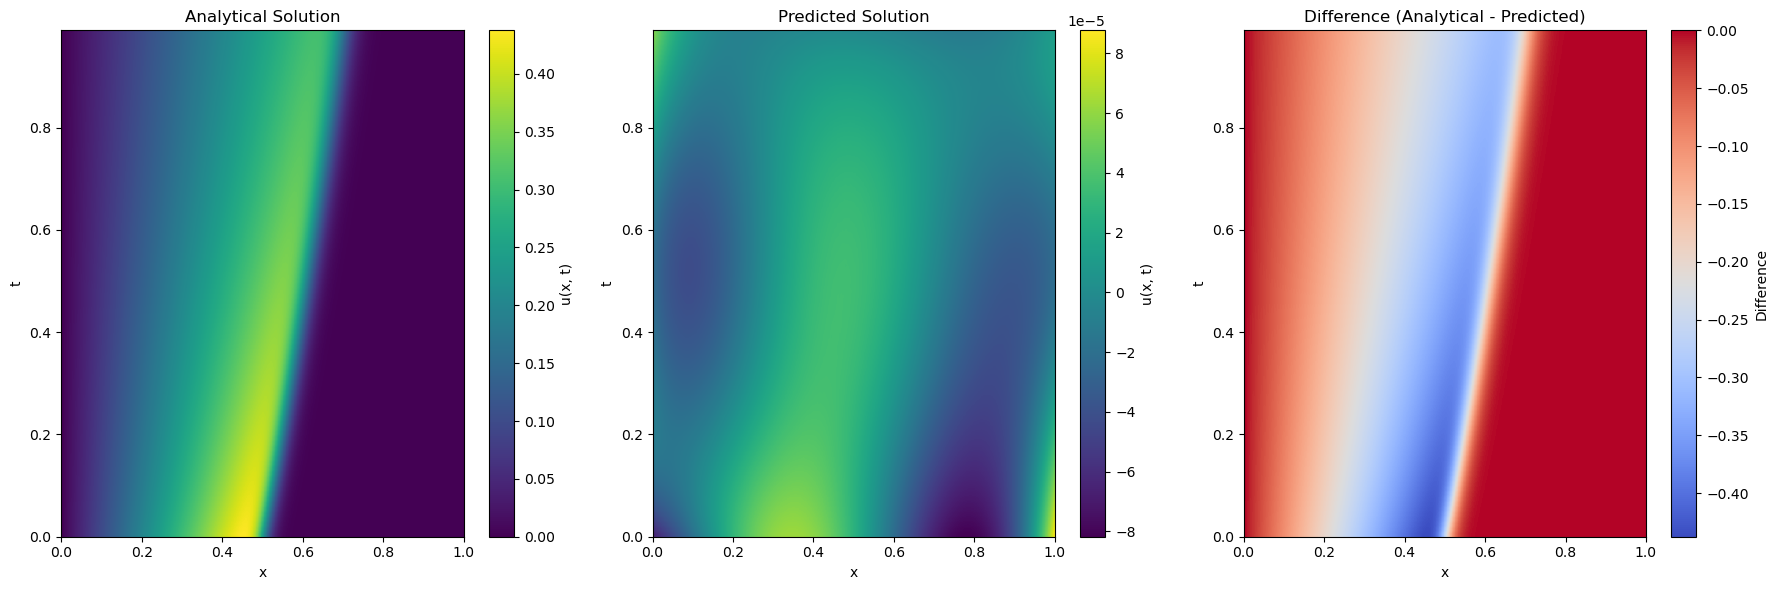

In [4]:
# Reshape y_true and y_pred back into the shape of the grid for plotting
y_true_reshaped = y_true_fixed.reshape(len(t), len(x))
y_pred_reshaped = y_pred_fixed.reshape(len(t), len(x))

# Create a figure with subplots for comparison
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot analytical solution heatmap
# im1 = axs[0].imshow(y_true_reshaped, extent=[x.min(), x.max(), t.min(), t.max()],
#                     origin='lower', aspect='auto', cmap='viridis')
im1 = axs[0].imshow(usol, extent=[x.min(), x.max(), t.min(), t.max()], 
           origin='lower', aspect='auto', cmap='viridis')
axs[0].set_title("Analytical Solution")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")
fig.colorbar(im1, ax=axs[0], label="u(x, t)")

# Plot predicted solution heatmap
im2 = axs[1].imshow(y_pred_reshaped, extent=[x.min(), x.max(), t.min(), t.max()],
                    origin='lower', aspect='auto', cmap='viridis')
axs[1].set_title("Predicted Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")
fig.colorbar(im2, ax=axs[1], label="u(x, t)")

# Plot difference heatmap
diff = y_pred_reshaped - usol
im3 = axs[2].imshow(diff, extent=[x.min(), x.max(), t.min(), t.max()],
                    origin='lower', aspect='auto', cmap='coolwarm')
axs[2].set_title("Difference (Analytical - Predicted)")
axs[2].set_xlabel("x")
axs[2].set_ylabel("t")
fig.colorbar(im3, ax=axs[2], label="Difference")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Part (b): Combined Inverse-Forward Problem

Training for combined inverse-forward problem
Compiling model...
Building feed-forward neural network...
'build' took 0.059414 s

'compile' took 0.473696 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.64e-01, 3.13e-01, 1.04e-01]    [3.64e-01, 3.13e-01, 1.04e-01]    []  
1000      [nan, nan, nan]                   [nan, nan, nan]                   []  

Best model at step 0:
  train loss: 7.80e-01
  test loss: 7.80e-01
  test metric: []

'train' took 3.083161 s

Compiling model...
'compile' took 0.267413 s

Training model...

Step      Train loss                        Test loss                         Test metric
1000      [nan, nan, nan]                   [nan, nan, nan]                   []  
INFO:tensorflow:Optimization terminated with:
  Message: ABNORMAL_TERMINATION_IN_LNSRCH
  Objective function value: nan
  Number of iterations: 0
  Number of functions evaluations: 52
1104      [nan, nan, nan]         

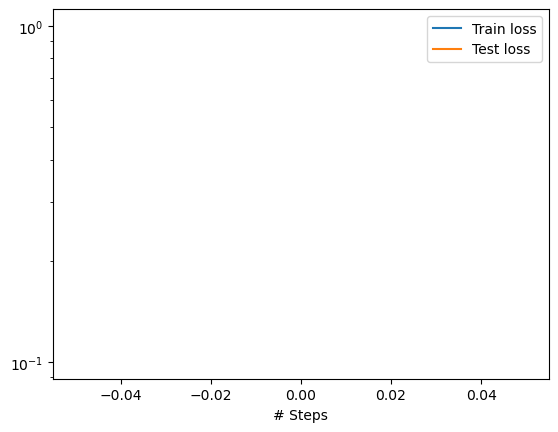

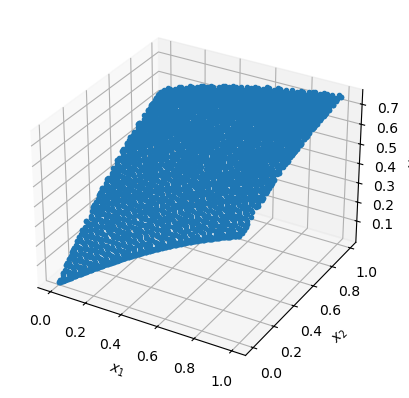

Mean residual for trainable Re: nan
L2 relative error for trainable Re: nan

Learned Reynolds number: 300.0


In [5]:
# Define Reynolds number as a trainable variable
Re_trainable = tf.Variable(Re_fixed, trainable=True, dtype=tf.float32)

# Generate analytical test data
def gen_testdata():
    data = np.load("dataset/Burgers.npz")  # Ensure the file is present in the correct location
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

# Define the PDE
def pde_trainable(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 3 / Re_trainable * dy_xx # Re=Re_fixed/100

# Define the domain and conditions
geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial condition matches the analytical solution
to = tf.exp(Re_trainable / 8)
ic = dde.IC(
    geomtime,
    lambda x: x[:, 0:1] / (1 + tf.sqrt(to) * tf.exp(Re_trainable * x[:, 0:1]**2 / 4)),
    lambda _, on_initial: on_initial,
)

# Dirichlet boundary conditions
bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)

# Solve the combined inverse-forward problem
print("Training for combined inverse-forward problem")

# Define dataset for trainable Re
data_trainable = dde.data.TimePDE(
    geomtime, pde_trainable, [bc, ic], num_domain=2540, num_boundary=80, num_initial=160
)

# Define the neural network
net_trainable = dde.maps.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

# Compile the model
model_trainable = dde.Model(data_trainable, net_trainable)
model_trainable.compile("adam", lr=1e-3)

# Train the model
model_trainable.train(epochs=15000)
model_trainable.compile("L-BFGS")
losshistory_trainable, train_state_trainable = model_trainable.train()

# Save results
dde.saveplot(losshistory_trainable, train_state_trainable, issave=True, isplot=True)

# Test the model
X_trainable, y_true_trainable = gen_testdata()
y_pred_trainable = model_trainable.predict(X_trainable)
f_trainable = model_trainable.predict(X_trainable, operator=pde_trainable)

# Print errors
print("Mean residual for trainable Re:", np.mean(np.absolute(f_trainable)))
print("L2 relative error for trainable Re:", dde.metrics.l2_relative_error(y_true_trainable, y_pred_trainable))

# Use a TensorFlow session to evaluate Re_trainable
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    learned_Re = sess.run(Re_trainable)

print("Learned Reynolds number:", learned_Re)

# Save test results
np.savetxt(f"test_trainable_Re_{learned_Re}.dat", np.hstack((X_trainable, y_true_trainable, y_pred_trainable)))


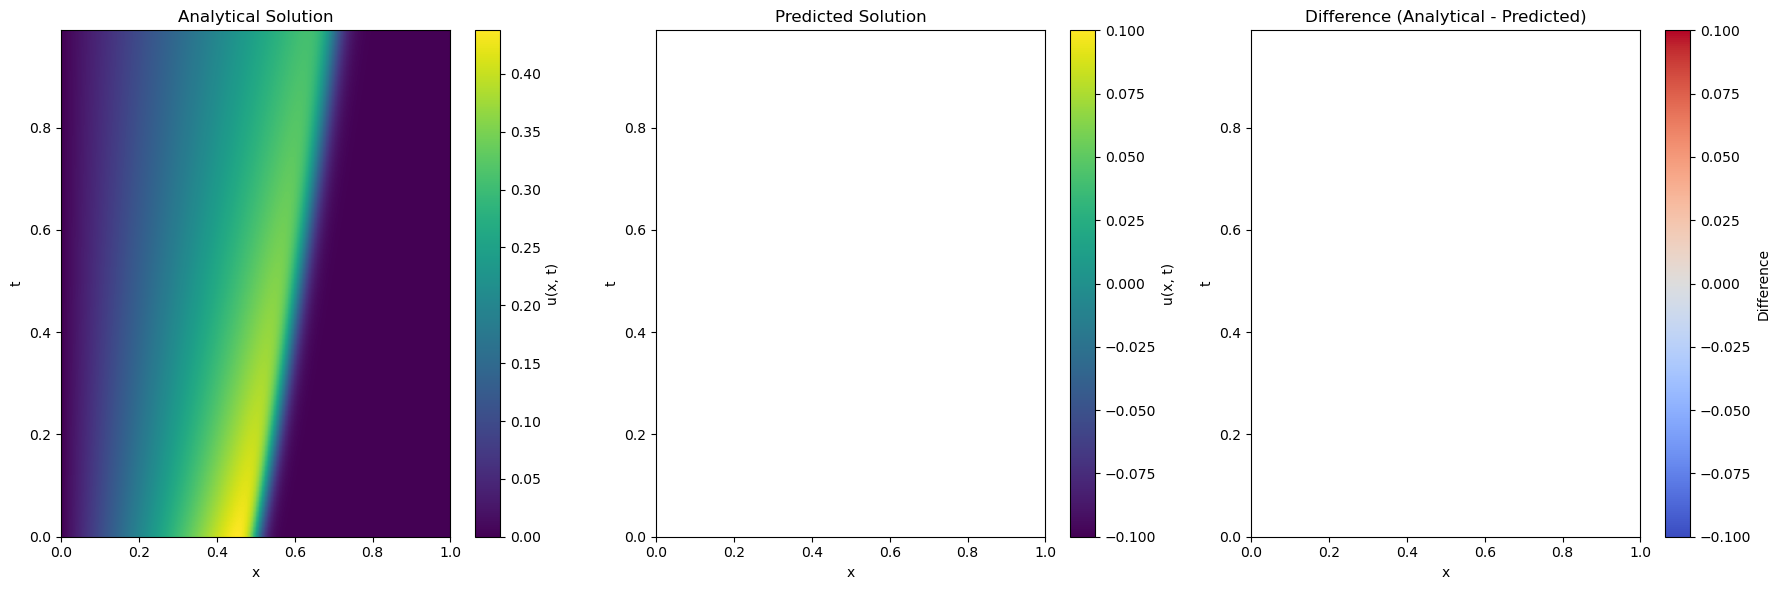

In [6]:
# Reshape y_true and y_pred back into the shape of the grid for plotting
y_true_reshaped = y_true_trainable.reshape(len(t), len(x))
y_pred_reshaped = y_pred_trainable.reshape(len(t), len(x))

# Create a figure with subplots for comparison
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot analytical solution heatmap
# im1 = axs[0].imshow(y_true_reshaped, extent=[x.min(), x.max(), t.min(), t.max()],
#                     origin='lower', aspect='auto', cmap='viridis')
im1 = axs[0].imshow(usol, extent=[x.min(), x.max(), t.min(), t.max()], 
           origin='lower', aspect='auto', cmap='viridis')
axs[0].set_title("Analytical Solution")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")
fig.colorbar(im1, ax=axs[0], label="u(x, t)")

# Plot predicted solution heatmap
im2 = axs[1].imshow(y_pred_reshaped, extent=[x.min(), x.max(), t.min(), t.max()],
                    origin='lower', aspect='auto', cmap='viridis')
axs[1].set_title("Predicted Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")
fig.colorbar(im2, ax=axs[1], label="u(x, t)")

# Plot difference heatmap
diff = y_pred_reshaped - usol
im3 = axs[2].imshow(diff, extent=[x.min(), x.max(), t.min(), t.max()],
                    origin='lower', aspect='auto', cmap='coolwarm')
axs[2].set_title("Difference (Analytical - Predicted)")
axs[2].set_xlabel("x")
axs[2].set_ylabel("t")
fig.colorbar(im3, ax=axs[2], label="Difference")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()